In [1]:
from pygeotools.lib import geolib,iolib,warplib
import numpy as np
import os,sys,glob,shutil
import matplotlib.pyplot as plt
from imview import pltlib

In [2]:
img_fn = '/nobackup/sbhusha1/feature_tracking_wg/LC08_L1TP_062017_20180903_20180912_01_T1_B8_s.TIF'
img_ds = iolib.fn_getds(img_fn)
img_ma = iolib.ds_getma(img_ds)

/nobackupp11/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

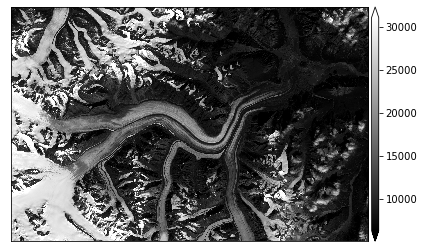

In [3]:
f,ax = plt.subplots()
pltlib.iv(img_ma,ax=ax,cmap='gray')

In [4]:
img_ds.RasterXSize

3780

In [5]:
img_ma.shape

(2480, 3780)

In [10]:
ny,nx = img_ma.shape

#### divide multi-pixel shifts incremently into blocks of 500 * 500 pixels

In [19]:
shift_arx = np.zeros((ny,nx))

In [20]:
shift_arx[:,:500] = 1.0

In [21]:
shift_arx

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [22]:
shift_arx[:,500:1000] = 2

In [23]:
shift_arx

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [24]:
shift_arx[:,1000:1500] = 3

In [25]:
shift_arx[:,1500:2000] = 4
shift_arx[:,2000:2500] = 5
shift_arx[:,2500:3000] = 6
shift_arx[:,3000:3500] = 7
shift_arx[:,3500:] = 8

/nobackupp11/sbhusha1/sw/imview/imview/lib/pltlib.py:146: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cmap.set_bad('0.5', alpha=1)


<AxesSubplot:>

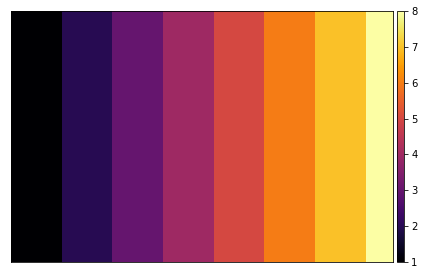

In [26]:
f,ax = plt.subplots()
pltlib.iv(shift_arx,ax=ax,cmap='inferno')

### now create a similar array with shift in y direction

In [27]:
shift_ary = np.zeros((ny,nx))

In [28]:
shift_ary[:500,] = -1
shift_ary

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [29]:
shift_ary[500:1000,:] = -2
shift_ary[1000:1500,:] = -3
shift_ary[1500:2000,:] = -4
shift_ary[2000:,:] = -5


<AxesSubplot:>

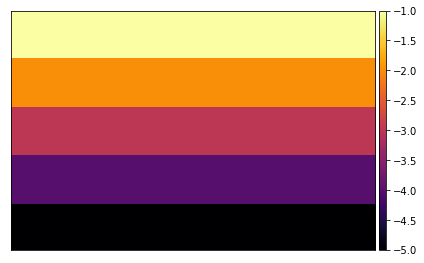

In [30]:
f,ax = plt.subplots()
pltlib.iv(shift_ary,ax=ax,cmap='inferno')

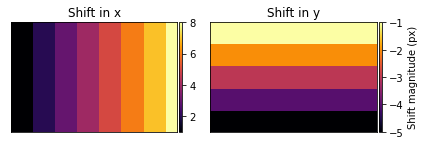

In [31]:
f,ax = plt.subplots(1,2)
pltlib.iv(shift_arx,ax=ax[0],title='Shift in x',cmap='inferno')
pltlib.iv(shift_ary,ax=ax[1],title='Shift in y',cmap='inferno',label='Shift magnitude (px)')
plt.tight_layout()

In [32]:
outfn_vx_integer_pixel = '/nobackup/sbhusha1/feature_tracking_wg/vx_integer.tif'
outfn_vy_integer_pixel = '/nobackup/sbhusha1/feature_tracking_wg/vy_integer.tif'
iolib.writeGTiff(shift_arx,outfn_vx_integer_pixel,src_ds=img_ds)
iolib.writeGTiff(shift_ary,outfn_vy_integer_pixel,src_ds=img_ds)

### Perform the pixel shifting
###### https://stackoverflow.com/questions/56143632/how-to-estimate-a-sub-pixel-shift-between-images-with-non-uniform-translation-ro

In [11]:
## get initial coordinate position using meshgrid
nx_val = np.arange(0,nx)
ny_val = np.arange(0,ny)

In [59]:
img_ma.shape

(2480, 3780)

In [12]:
NX,NY = np.meshgrid(nx_val,ny_val)

In [61]:
NX.shape

(2480, 3780)

In [62]:
NY.shape

(2480, 3780)

In [63]:
NX_shift = NX + shift_arx
NY_shift = NY + shift_ary

In [3]:
import scipy.ndimage

In [65]:
yx = np.array([np.ma.array(NY_shift).compressed(),np.ma.array(NX_shift).compressed()])

In [66]:
#h2_samp = scipy.ndimage.map_coordinates(h, yx, order=1,mode='nearest')
shift_samp = scipy.ndimage.map_coordinates(img_ma,yx,order=1,mode='nearest')

In [67]:
shift_samp

array([8139, 8466, 8893, ..., 7669, 7669, 7669], dtype=uint16)

In [30]:
np.ma.array(NY_shift).compressed()

array([-1.200e+00, -1.200e+00, -1.200e+00, ...,  2.477e+03,  2.477e+03,
        2.477e+03])

In [68]:
shift_img = np.zeros_like(img_ma)
shift_img[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = shift_samp

/nobackupp11/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

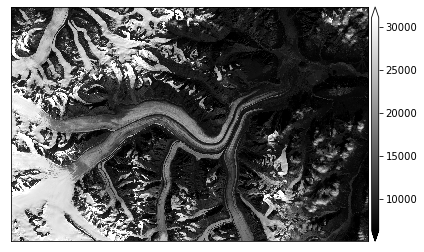

In [69]:
f,ax = plt.subplots()
pltlib.iv(np.ma.fix_invalid(shift_img),ax=ax,cmap='gray')

In [70]:
outfn = os.path.splitext(img_fn)[0]+'_multi_pixel_synthetic_shift.tif'
iolib.writeGTiff(shift_img,outfn,src_ds=img_ds)

### Add a known deformation field to the glacier ? Maybe steal from ITS_LIVE ?

In [4]:
its_live_vx_fn = '/nobackup/sbhusha1/feature_tracking_wg/its_live/vx_240m_its_live.tif'
its_live_vy_fn = '/nobackup/sbhusha1/feature_tracking_wg/its_live/vy_240m_its_live.tif'
ds_list = warplib.memwarp_multi_fn([img_fn,its_live_vx_fn,its_live_vy_fn],r='cubicspline')
its_live_vx,its_live_vy = [iolib.ds_getma(ds_list[x]) for x in [1,2]]


Warping all inputs to the following:
Resolution: 15.0
Extent: [584872.5, 6717982.5, 641572.5, 6755182.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubicspline

1 of 3: /nobackup/sbhusha1/feature_tracking_wg/LC08_L1TP_062017_20180903_20180912_01_T1_B8_s.TIF
2 of 3: /nobackup/sbhusha1/feature_tracking_wg/its_live/vx_240m_its_live.tif
nl: 2480 ns: 3780 res: 15.000
3 of 3: /nobackup/sbhusha1/feature_tracking_wg/its_live/vy_240m_its_live.tif
nl: 2480 ns: 3780 res: 15.000


/nobackupp11/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

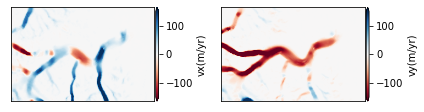

In [5]:
f,ax = plt.subplots(1,2)
clim = (-150,150)
pltlib.iv(its_live_vx,ax=ax[0],cmap='RdBu',label='vx(m/yr)',clim=clim)
pltlib.iv(its_live_vy,ax=ax[1],cmap='RdBu',label='vy(m/yr)',clim=clim)

In [6]:
### assume dt = 0.5 yr and value of 15 m pixel size. so displacement in pixel is a*0.5/15.
its_live_vx = (its_live_vx*0.5)/15
its_live_vy = (its_live_vy*0.5)/15

<AxesSubplot:>

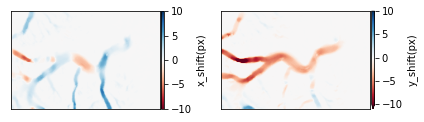

In [7]:
f,ax = plt.subplots(1,2)
clim = (-10,10)
pltlib.iv(its_live_vx,ax=ax[0],cmap='RdBu',label='x_shift(px)',clim=clim)
pltlib.iv(its_live_vy,ax=ax[1],cmap='RdBu',label='y_shift(px)',clim=clim)

In [13]:
NX_shift_deformation_feild = NX + its_live_vx
NY_shift_deformation_feild = NY + its_live_vy

In [14]:
yx = np.array([np.ma.array(NY_shift_deformation_feild).compressed(),np.ma.array(NX_shift_deformation_feild).compressed()])
shift_samp = scipy.ndimage.map_coordinates(img_ma,yx,order=1,mode='nearest')
shift_img_deformation = np.zeros_like(img_ma)
shift_img_deformation[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = shift_samp

/nobackupp11/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

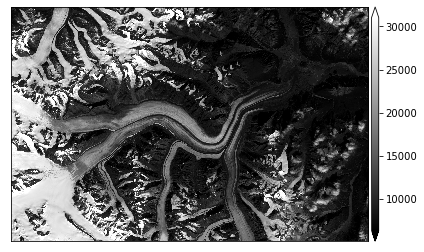

In [15]:
f,ax = plt.subplots()
pltlib.iv(np.ma.fix_invalid(shift_img_deformation),ax=ax,cmap='gray')

In [16]:
outfn = os.path.splitext(img_fn)[0]+'_deformation_synthetic_shift.tif'
iolib.writeGTiff(shift_img_deformation,outfn,src_ds=img_ds)

###### Write out shift grids

In [17]:
img_fn

'/nobackup/sbhusha1/feature_tracking_wg/LC08_L1TP_062017_20180903_20180912_01_T1_B8_s.TIF'

In [18]:
outfn_vx_deformation = '/nobackup/sbhusha1/feature_tracking_wg/vx_deformation.tif'
outfn_vy_deformation = '/nobackup/sbhusha1/feature_tracking_wg/vy_deformation.tif'
iolib.writeGTiff(its_live_vx,outfn_vx_deformation,src_ds=img_ds)
iolib.writeGTiff(its_live_vy,outfn_vy_deformation,src_ds=img_ds)

### Add noises, maybe blur noise, etc
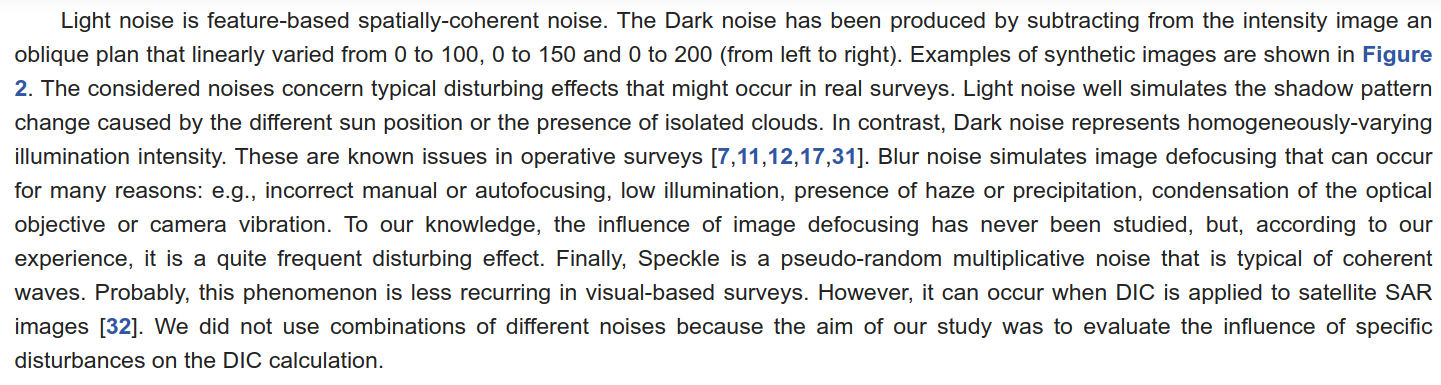

## Run correlator and check disparity

In [130]:
outdisp_fn = '/nobackupp2/sbhusha1/vmap_comparison_testing/LC08_L1TP_062017_20180903_20180912_01_T1_B8_s__LC08_L1TP_062017_20180903_20180912_01_T1_B8_s_synthetic_shift_vmap_minm_35px_spm1/vmap-F.tif'
dx,dy = [iolib.fn_getma(outdisp_fn,x) for x in range(1,3)]

In [115]:
%matplotlib notebook

In [117]:
#Looks like i compared in reverse direction, so multiplying by -1

<IPython.core.display.Javascript object>


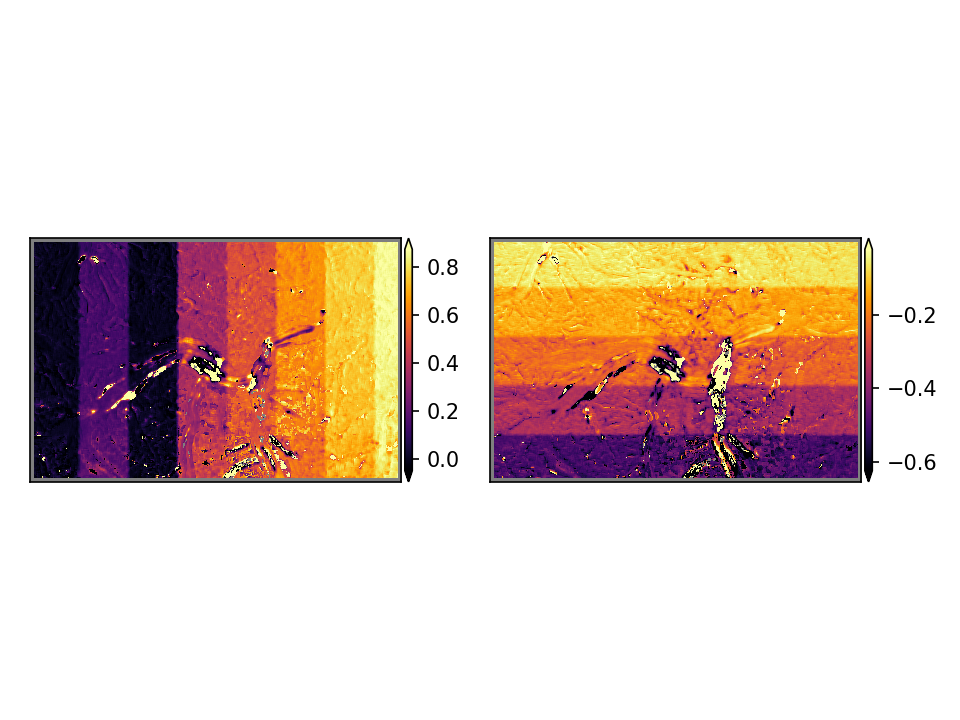

In [118]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx,cmap='inferno',ax=ax[0])
pltlib.iv(-1*dy,cmap='inferno',ax=ax[1])

<IPython.core.display.Javascript object>


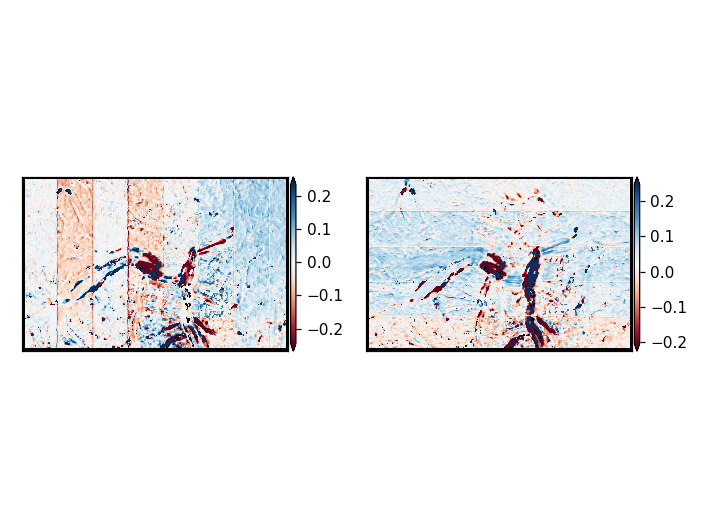

In [131]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx-shift_arx,cmap='RdBu',ax=ax[0])
pltlib.iv(-1*dy-shift_ary,cmap='RdBu',ax=ax[1])

In [132]:
from pygeotools.lib import malib

In [135]:
dx_med = np.ma.median(-1*dx-shift_arx)
dx_nmad = malib.mad(-1*dx-shift_arx)
dy_med = np.ma.median(-1*dy-shift_ary)
dy_nmad = malib.mad(-1*dy-shift_ary)
print(f"dx median bias:{np.round(dx_med,2)} px, dx nmad variability:{np.round(dx_nmad,2)} px")
print(f"dy median bias:{np.round(dy_med,2)} px, dy nmad variability:{np.round(dy_nmad,2)} px")

dx median bias:0.0 px, dx nmad variability:0.06 px
dy median bias:0.04 px, dy nmad variability:0.04 px


### Experimental Phase correlator in ASP

In [136]:
outdisp_fn = '/nobackupp2/sbhusha1/vmap_comparison_testing/block_matching_phase_subpixel/run-F.tif'
dx,dy = [iolib.fn_getma(outdisp_fn,x) for x in range(1,3)]

<IPython.core.display.Javascript object>


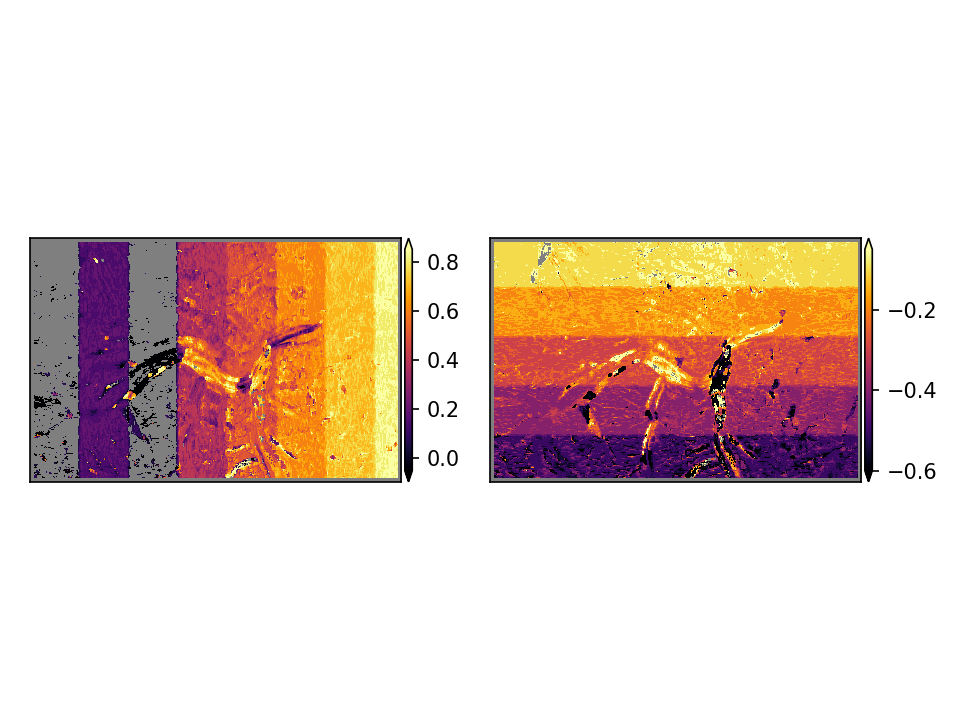

In [124]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx,cmap='inferno',ax=ax[0])
pltlib.iv(-1*dy,cmap='inferno',ax=ax[1])

<IPython.core.display.Javascript object>


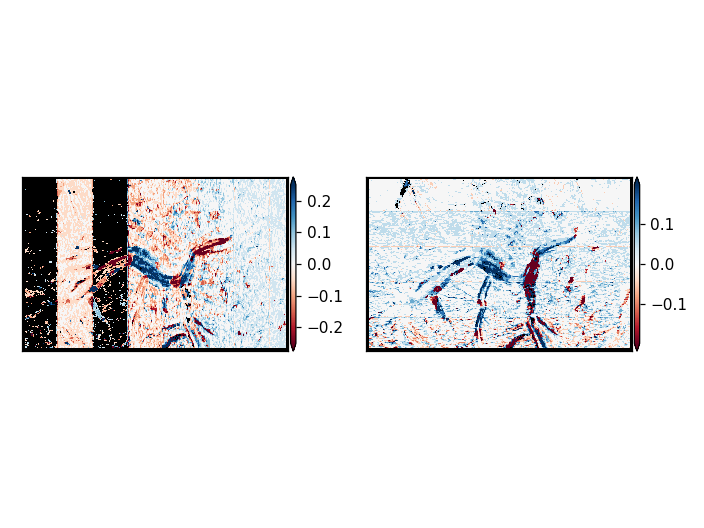

In [137]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx-shift_arx,cmap='RdBu',ax=ax[0])
pltlib.iv(-1*dy-shift_ary,cmap='RdBu',ax=ax[1])

In [138]:
dx_med = np.ma.median(-1*dx-shift_arx)
dx_nmad = malib.mad(-1*dx-shift_arx)
dy_med = np.ma.median(-1*dy-shift_ary)
dy_nmad = malib.mad(-1*dy-shift_ary)
print(f"dx median bias:{np.round(dx_med,2)} px, dx nmad variability:{np.round(dx_nmad,2)} px")
print(f"dy median bias:{np.round(dy_med,2)} px, dy nmad variability:{np.round(dy_nmad,2)} px")

dx median bias:0.0 px, dx nmad variability:0.07 px
dy median bias:-0.0 px, dy nmad variability:0.0 px


#### Sub-pixel refinement Bayes-EM? This should be the best we have.

In [139]:
outdisp_fn = '/nobackupp2/sbhusha1/vmap_comparison_testing/LC08_L1TP_062017_20180903_20180912_01_T1_B8_s__LC08_L1TP_062017_20180903_20180912_01_T1_B8_s_synthetic_shift_vmap_minm_35px_spm2/vmap-F.tif'
dx,dy = [iolib.fn_getma(outdisp_fn,x) for x in range(1,3)]

<IPython.core.display.Javascript object>


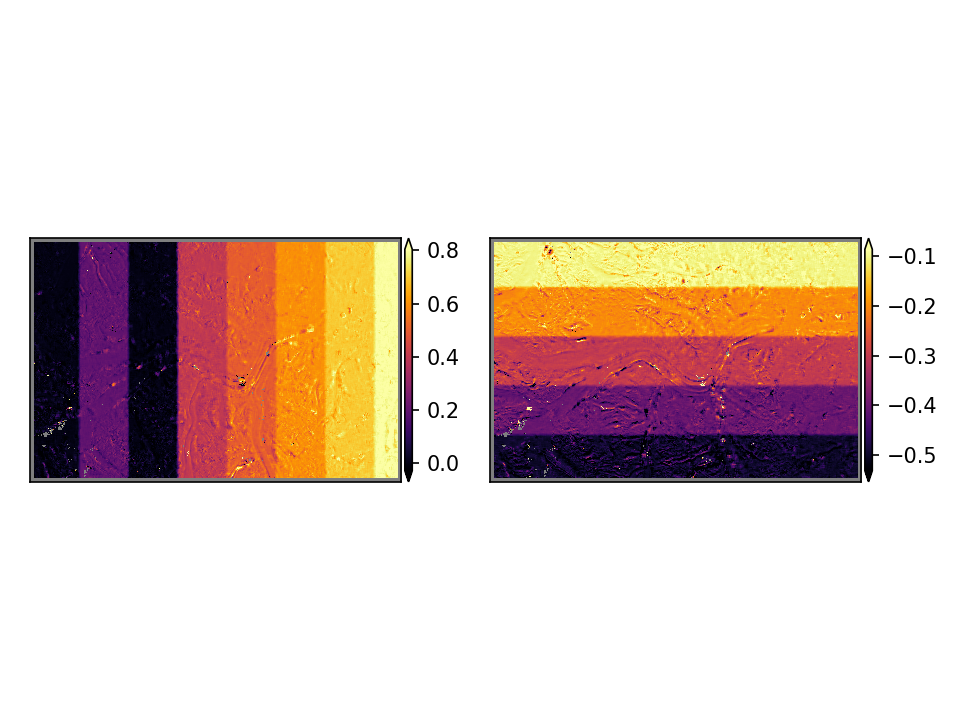

In [126]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx,cmap='inferno',ax=ax[0])
pltlib.iv(-1*dy,cmap='inferno',ax=ax[1])

<IPython.core.display.Javascript object>


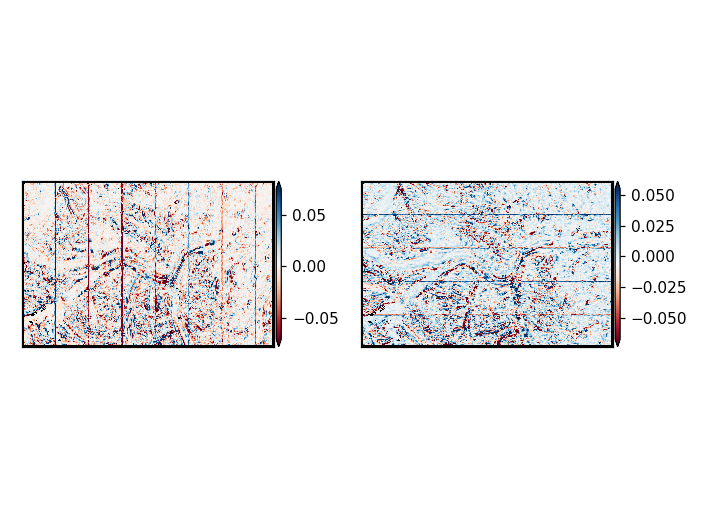

In [140]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx-shift_arx,cmap='RdBu',ax=ax[0])
pltlib.iv(-1*dy-shift_ary,cmap='RdBu',ax=ax[1])

In [141]:
dx_med = np.ma.median(-1*dx-shift_arx)
dx_nmad = malib.mad(-1*dx-shift_arx)
dy_med = np.ma.median(-1*dy-shift_ary)
dy_nmad = malib.mad(-1*dy-shift_ary)
print(f"dx median bias:{np.round(dx_med,2)} px, dx nmad variability:{np.round(dx_nmad,2)} px")
print(f"dy median bias:{np.round(dy_med,2)} px, dy nmad variability:{np.round(dy_nmad,2)} px")

dx median bias:0.0 px, dx nmad variability:0.02 px
dy median bias:-0.0 px, dy nmad variability:0.01 px


#### Affine non-adaptive 

In [142]:
outdisp_fn = '/nobackupp2/sbhusha1/vmap_comparison_testing/LC08_L1TP_062017_20180903_20180912_01_T1_B8_s__LC08_L1TP_062017_20180903_20180912_01_T1_B8_s_synthetic_shift_vmap_minm_35px_spm3/vmap-F.tif'
dx,dy = [iolib.fn_getma(outdisp_fn,x) for x in range(1,3)]

<IPython.core.display.Javascript object>


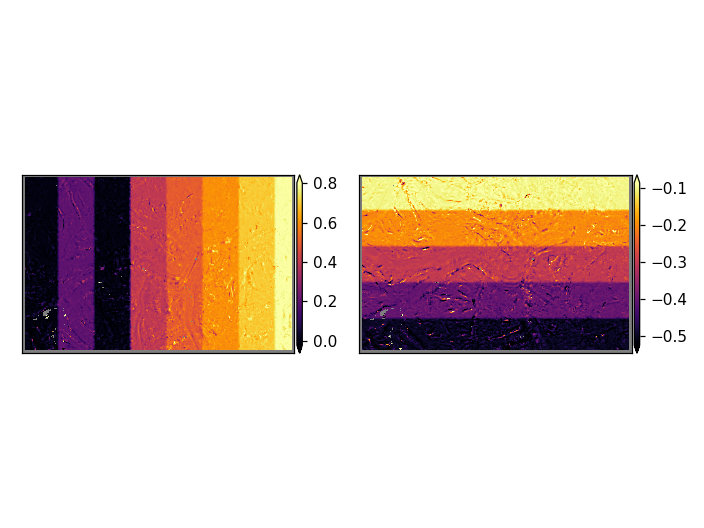

In [129]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx,cmap='inferno',ax=ax[0])
pltlib.iv(-1*dy,cmap='inferno',ax=ax[1])

<IPython.core.display.Javascript object>


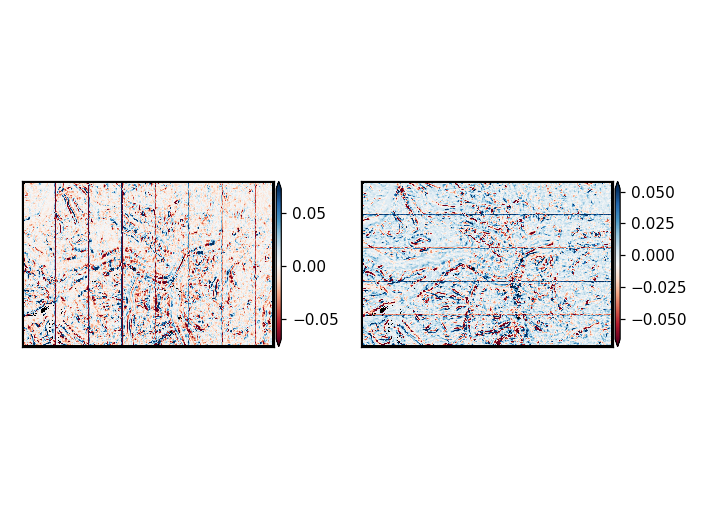

In [143]:
f,ax = plt.subplots(1,2)
pltlib.iv(-1*dx-shift_arx,cmap='RdBu',ax=ax[0])
pltlib.iv(-1*dy-shift_ary,cmap='RdBu',ax=ax[1])

In [144]:
dx_med = np.ma.median(-1*dx-shift_arx)
dx_nmad = malib.mad(-1*dx-shift_arx)
dy_med = np.ma.median(-1*dy-shift_ary)
dy_nmad = malib.mad(-1*dy-shift_ary)
print(f"dx median bias:{np.round(dx_med,2)} px, dx nmad variability:{np.round(dx_nmad,2)} px")
print(f"dy median bias:{np.round(dy_med,2)} px, dy nmad variability:{np.round(dy_nmad,2)} px")

dx median bias:-0.0 px, dx nmad variability:0.01 px
dy median bias:-0.0 px, dy nmad variability:0.01 px
